# Homework 7: $k$-Nearest Neighbors and $k$-Means Clustering

Practical Assignment Objectives:
- Implement the $k$-Nearest Neighbors algorithm from scratch in order to classify and predict data
- To implement the $k$-Means algorithm from scratch in order to cluster data.

We use as reference the chapter 19 and 22 of Understanding Machine Learning.

Copy this notebook and insert the corresponding names on the file.


## Important!


1.   **You shall send this TP by mail with the subject: [HW7][Student_1]_[Student_2]** (Adapt the subject accordingly to your specific situation).

2.   **This exercise can be done in pairs. Please, leave all of your answers on this notebook, which will be the only file you will have to deliver.**

3. **You have one week to deliver the homework.**

4. **Comment your code. If you leave an algorithm unfinished or you believe it may have a problem handling specific cases, we will consider this for evaluation.**

5. **We strongly encourage discussion between students as long as you own your solution. Copy pasting the solution from internet/colleagues will not be tolerated.**

 
**Send your solutions to both mails:**

<code>breno.skuk@gmail.com<br>
ibrahim.djemai@telecom-sudparis.eu</code>

(Feel free to send an email if you have any question concerning the TP)

**Good luck!**

Lais Isabelle Alves dos Santos

Louis Chanaron


# Working with the $k$-NN algorithm

The $k$-Nearest-Neighbor algorithm (or, shortly, $k$-NN) is a supervised classification algorithm. It works as follows: given a data set $S^m$, an integer $1\leq k\leq m$, and a new sample $\mathbf{x}$, consider the set
$S_k(\mathbf{x})$ whose elements are the $k$ elements of $S^m$ that are the closest to $\mathbf{x}$---this implicitly assumes the existence of a metric, for instance the Euclidean distance. The label assigned to $\mathbf{x}$ is majority label in $S_k(\mathbf{x})$. Figure 1 illustrates this label assignment for three classes.

<img src="https://i.ibb.co/R7DMvxM/Figure-1.png" alt="Figure-1" border="0">

# Working with $k$-Means Clustering
The k-Means Clustering is one of the most popular machine learning algorithms for cluster analysis in data mining. The $k$-Means algorithm is an unsupervised learning algorithm that aims to group "similar" items into $k$ groups. Figure 2 illustrates k-Means with 3 classes.

Given a (training) data set and a distance metric, the algorithm starts from $k$ points in the data domain (the centroids). These $k$ points are typically randomly chosen. Each data point is assigned to the closest centroid. This gives $k$ family of points labelled by their centroids. The centroids are updated to the cluster center of each family. Repeat these steps until convergence is achieved, or up to a maximum number of iterations, or when the difference between the old and the new centroids is negligible.

<img src="https://i.ibb.co/R7t1ykM/skhjfysqjflzjdfhzef.png" alt="skhjfysqjflzjdfhzef" border="0">

*K-Means algorithm.*

<img src="https://i.ibb.co/njwxhNj/Figure-2.png" alt="Figure-2" border="0">

# Part 1: Implementation and synthetic data

## 1. Toy data set
In this part we will implement the $k$-NN algorithm for classification and the $k$-Means algorithm for clustering.

Consider a data set $\{(\mathbf{x}(n), y(n))\}_{n=1}^{300}$ consisting of 300 points $\mathbf{x}(n) = (x_1(n), x_2(n)) \in \mathbb{R}^2$, and their labels $y(n) \in \{0, 1, 2\}$ generated as follows:

→ The first 100 points have label $y(n) = 0$ and are generated according to a Gaussian distribution $\mathbf{x}(n) \sim \mathcal{N}([-1, 0], \sigma^2\mathbf{I})$

→ the next 100 points have label $y(n) = 1$ and are generated according to a Gaussian distribution $\mathbf{x}(n) \sim \mathcal{N}([1, 0], \sigma^2\mathbf{I})$

→ and the remaining 100 points have label $y(n) = 2$ and are generated according to a Gaussian distribution $\mathbf{x}(n) \sim \mathcal{N}([0, 1], \sigma^2\mathbf{I})$. 

- Shuffle and split the data set into a training and a test set, containing respectively $75\%$ and $25\%$ of the data set.

In [ ]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as met
import math

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression as OLS

from urllib import request
import pandas as pd
from seaborn import heatmap

In [ ]:
def genData(N, mean1, mean2, mean3, sigma):
  """
  Generate the data set.
  
  Parameters
  -----------
  `N`: Size of the data set
  `means` Mean vectors for each part, Dimension: [3 x 2]
  `sigma` Standard deviation
  
  Returns
  -------
  `x`: Input data, Dimension: [N x 2]
  `y`: Labels, Dimension: [N x 1]
  """
  X1 = rd.multivariate_normal(mean1, sigma*np.eye(2), size=int(np.ceil(N//3)))
  X0 = rd.multivariate_normal(mean2, sigma*np.eye(2), size=(N//3))
  X2 = rd.multivariate_normal(mean3, sigma*np.eye(2), size=(N//3))

  Y1 = np.ones(len(X1))
  Y0 = np.zeros(len(X0))
  Y2 = 2*np.ones(len(X2))

  X = np.concatenate((X0, X1, X2))
  Y = np.concatenate((Y0, Y1, Y2))[:, np.newaxis]
  Z = np.concatenate((X, Y), axis=1)
  rd.shuffle(Z)
  X = Z[:, 0:2].T
  #X = np.concatenate((np.ones(len(X[0]))[np.newaxis], X), axis=0) # X is in homogeneous coordinates
  Y = Z[:, 2]
  return X, Y


def splitData(x, y, p=0.75):
  """
  Split the data set randomly into a training set and a test set.
  
  Parameters
  -----------
  `x`: Input data, Dimension:  [N x 2]
  `y`: Labels, Dimension: [N x 1]
  `p`: ratio of training samples
  
  Returns
  -------
  `xTrain`: Input data for training, Dimension: [p.N x 2]
  `yTrain`: Labels for training, Dimension: [p.N x 1]
  `xTest`: Input data for testing, Dimension: [(1-p).N x 2]
  `yTest`: Labels for testing, Dimension: [(1-p).N x 1]
  """
  Z = np.concatenate((x, y), axis=1)
  rd.shuffle(Z)
  x = Z[:, 0:2].T
  x = np.concatenate((np.ones(len(x[0]))[np.newaxis], x), axis=0) # X is in homogeneous coordinates
  y = Z[:, 2]
  N = int(p*len(y))
  xtrain = x[:, :N]
  ytrain = y[: N]
  xtest = x[:, N:]
  ytest = y[N:]
  return xtrain, ytrain, xtest, ytest

## $k$-NN algorithm for classification
### Question 1:

- Fix the variance $\sigma^2 = 0.10$ and $k=1$ and run the algorithm to classify the test set.
- In order to visualize all data set and the corresponding label, plot all generated points in a coordinate plane, and the estimated decision boundary, similarly to Figure 3.
- Perform the classification with $\sigma^2 \in \{0.10, 0.20, 0.25\}$ repeated 50 times each, with randomly generated training and test sets at each time.
- Plot the average error rate of the test data set *versus* the variance $\sigma^2$, use error bars to represent the standard deviation. Comment.

*Hint: Use* `matplotlib.pyplot.countourf` *to plot the decision boundary*

<img src="https://i.ibb.co/bgwRmT8/Screenshot-2022-10-23-165012.png" alt="Screenshot-2022-10-23-165012" border="0">

In [ ]:
def knnClassifier(k, xTrain, yTrain, xTest):
  """
  Classify the test set using the training set.
  
  Parameters
  -----------
  `k`: kNN parameter (number of neighbors to consider)
  `xTrain`: Input data for training
  `yTrain`: Labels for training
  `xTest`: Input data for testing
  
  Returns
  -------
  `yPred`: Predicted Labels
  """
  dist = np.zeros((len(xTest[0]), len(xTrain[0])))
  for i in range(len(xTrain[0])):
    for j in range(len(xTest[0])):
      dist[j, i] = (xTrain[:, i]-xTest[:, j]).T@(xTrain[:, i]-xTest[:, j])
  dist = np.argsort(dist, axis=1)
  res = []
  for j in range(len(xTest[0])):
    p0 = np.sum(yTrain[dist[j,:k]] == 0)
    p1 = np.sum(yTrain[dist[j,:k]] == 1)
    p2 = np.sum(yTrain[dist[j,:k]] == 2)
    if p0 < p1 and p2 < p1:
      res += [1]
    elif p1 < p0 and p2 < p0:
      res += [0]
    else:
      res += [2]
  return np.array(res)
  

def plotDataKNN(xTrain, yTrain, xTest, yTest, yPred):
  """
  Plot the data set and the decision boundaries for KNN.
  
  Parameters
  -----------
  `xTrain`: Input data for training
  `yTrain`: Labels for training
  `xTest`: Input data for testing
  `yTest`: Labels for testing
  `yPred`: Predicted Labels
  """

  xMin, xMax = xTrain[0, :].min() - 1, xTrain[0, :].max() + 1
  yMin, yMax = xTrain[1, :].min() - 1, xTrain[1, :].max() + 1
  xx, yy = np.meshgrid(np.arange(xMin, xMax, 0.1), np.arange(yMin, yMax, 0.1))

  XY = np.c_[xx.ravel(), yy.ravel()]  # Coordinates of the space
  
  # classify the coordinate with KNN
  Z = knnClassifier(k, xTrain, yTrain, XY.T)
  
  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  
  plt.figure(figsize=(10,10))
  plt.contourf(xx, yy, Z, alpha = 0.2, cmap = ListedColormap(('#f0027f', '#AAAAFF', '#FFFF00')))

  lab0 = np.array([int(yTrain[k]) == 0 for k in range(len(yTrain))])
  lab1 = np.array([int(yTrain[k]) == 1 for k in range(len(yTrain))])
  lab2 = np.array([int(yTrain[k]) == 2 for k in range(len(yTrain))])

  plt.scatter(xTrain[0, lab0], xTrain[1,lab0], c='b', marker='v')
  plt.scatter(xTrain[0, lab1], xTrain[1,lab1], c='g', marker='v')
  plt.scatter(xTrain[0, lab2], xTrain[1,lab2], c='k', marker='v')

  # TODO: Plot the data points, don't forget to count the wrong labeles examples seperatly
  lab0 = np.array([yPred[k] == 0 and yTest[k]==0 for k in range(len(yPred))])
  lab1 = np.array([yPred[k] == 1 and yTest[k]==1 for k in range(len(yPred))])
  lab2 = np.array([yPred[k] == 2 and yTest[k]==2 for k in range(len(yPred))])
  labFalse = yTest != yPred

  plt.scatter(xTest[0, lab0], xTest[1,lab0], c='b')
  plt.scatter(xTest[0, lab1], xTest[1,lab1], c='g')
  plt.scatter(xTest[0, lab2], xTest[1,lab2], c='k')
  plt.scatter(xTest[0, labFalse], xTest[1,labFalse], c='r')

  plt.title("decision boundary")
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.legend()
  plt.show()
  pass


def l01Loss(yTest, yPred):
  """
  Calculate the L_01 Loss
  
  Parameters
  -----------
  `yTest`: Labels for testing
  `yPred`: Predicted Labels

  Returns:
  --------
  `loss`: Computed Loss
  """
  return np.mean(yTest == yPred)

In [ ]:
k = 3
xTrain = np.array([[1, 2, 3, 4]])
yTrain = np.array([0, 1, 1, 2])
xTest = np.array([[1, -1]])
knnClassifier(k, xTrain, yTrain, xTest)

array([1, 1])

Triangles represent train data, circles test data


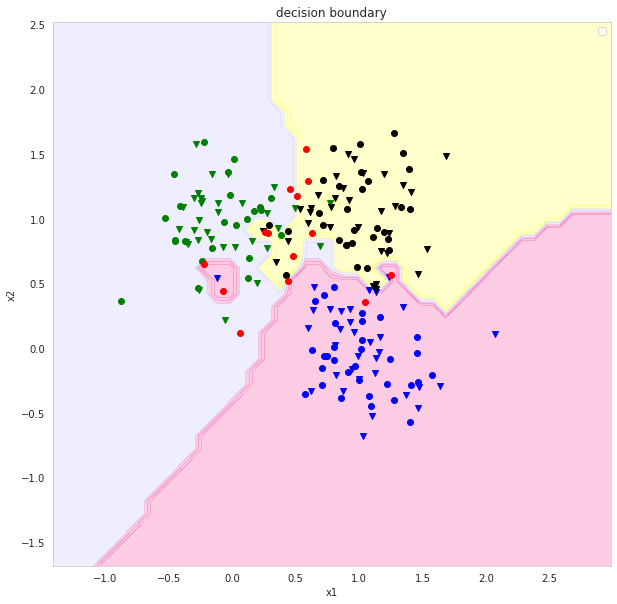

In [ ]:
XTrain, yTrain = genData(100, [0, 1], [1, 0], [1, 1], 0.1)
yTrain = np.array(yTrain, dtype='int')
XTest, yTest = genData(100, [0, 1], [1, 0], [1, 1], 0.1)
yPred = knnClassifier(1, XTrain, yTrain, XTest)
print('Triangles represent train data, circles test data')
plotDataKNN(XTrain, yTrain, XTest, yTest, yPred)
plt.show()

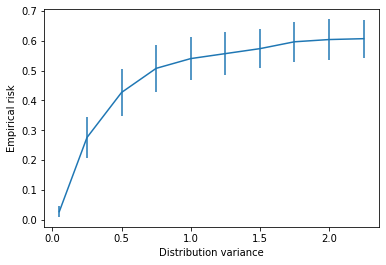

In [ ]:
sig_list = [0.05, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25]
n = len(sig_list)
N_training = 20
N_average = 100

err = np.zeros((n, N_average))
for k in range(n):
  for l in range(N_average):
      sig2 = sig_list[k]
      xtrain, ytrain = genData(N_training, [1, 0], [0, 1], [0, 0], sig_list[k])
      xtest, ytest = genData(N_average, [1, 0], [0, 1], [0, 0], sig_list[k])
      err[k, l] = 1-l01Loss(ytest, knnClassifier(5, xtrain, ytrain, xtest))

plt.errorbar(sig_list, np.mean(err, axis=1), yerr = np.std(err, axis=1))
plt.xlabel("Distribution variance")
plt.ylabel("Empirical risk")
plt.show()

This is a consistent result, the l01 empirical loss increases with the distribution of variances, in an exponential way. The standard deviation of sets distributions measures how well the clusters are separable. The standard deviation of losses is quite stable and does not seem to change much.

We use here **K-Fold Cross Validation**, a technique used for model validation. 

Suppose we are given $N$ (classification) models $h_i \in \mathcal{H}, i=\{1, \cdots, N\}$, a training set $(\mathbf{x}_{train}, y_{train})$, and a test set $(\mathbf{x}_{test}, y_{test})$.

Split the training set $(\mathbf{x}_{train}, y_{train})$ into $k$ folds, use $(k-1)$ folds to train and one fold to validate. Cycle through all folds, as shown in Figure 4, where we consider a different fold for testing at each cycle. For each model we report the average error of the $k$ folds. 

The selected model is the one with the smallest average error:

$$ h_{best} = \arg\min_{h_i \in \mathcal{H}} \frac{1}{k} \sum^{k}_{j=1}err(y_{valid}^{(j)}, \hat{y}_{valid}^{(j)}) \quad  i=\{1, \cdots, N\}$$

Once the model is selected, it is trained with the entire training set (with the validation part) $(\mathbf{x}_{train}, y_{train})$, and tested over the test data $(\mathbf{x}_{test}, y_{test})$.

<img src="https://i.ibb.co/KKWPLgk/1-AAw-Il-HM8-Tp-AVe4l2-Fih-NUQ.png" alt="1-AAw-Il-HM8-Tp-AVe4l2-Fih-NUQ" border="0" width=500>

*Figure 4: Visualization of the K-Fold Cross Validation training data splitting*





### Question 2:
With $\sigma^2 = 0.10$:
- Generate the dataset as in question 1, with a 75/25 training/test proportion.
- Compute the average error for each $k$-NN model, $k\in\{1,2,\ldots, 5\} $ (these are the "validation error" for each $k$). Plot the validation error as a function of $k$. Comment.
- Fit the best model on the entire training set and compute its error on the test set (plot the generated points as in question 1). Compare this error with validation error of the best model.
- Is there a better configuration of the number of folds to consider (e.g. $9$ or $15$ folds) ?

*Hint: Use* `sklearn.model_selection.KFold` *to split data.*

Optimal k: 1


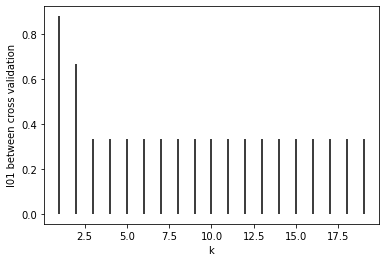

In [ ]:
from ast import NameConstant
k_list = range(1, 20)
sig = 0.1
N_training = 100
N_test = N_training//3
N_k = len(k_list)
N_fold = 5
xtrain, ytrain = genData(N_training, [1, 0], [0, 1], [0, 0], sig)
xtest, ytest = genData(N_test, [1, 0], [0, 1], [0, 0], sig)
l01 = np.zeros((N_k, N_fold))
for k in range(N_k):
  for l in range(N_fold):
    l01[k, l] = l01Loss(ytest, knnClassifier(k_list[k], xtrain[:, k::N_k], ytrain[k::N_k], xtest))
plt.vlines(k_list, np.zeros(len(l01)), np.mean(l01, axis=1))
plt.xlabel("k")
plt.ylabel("l01 between cross validation")
K = np.argmax(np.mean(l01, axis=1))+1
print("Optimal k:", K)
plt.show()

We can see that low values of k seems to define better knn model to deal with our normal synthetic data. We can understand it because our clusters are quite well separated one from the other.

In [ ]:
np.std(l01, axis=1)

array([1.11022302e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

As far as there does not seem to be any loss variation between the different folds, the number of folds is not very important. It can be explained by the fact that dealing with this synthetic normal data is quite simple.

## $k$-Means algorithm for clustering


### Question 3
Generate the data set with the same function from Question 2 with $\sigma^2 = 0.15$.

- Group the data set into three clusters $(k=3)$ using the $k$-Means algorithm with respect to the Euclidean distance.
- Repeat it with $k \in \{2, 4, 6\}$.
- Visualize all data set and the centroids at the convergence for each $k$. Comment.

In [ ]:
def kMeans(k, x, it):
  """
  k-Means Clustering of the data set with k centroids
  
  Parameters
  -----------
  `k`: k-Means parameter (Number of centroids)
  `x`: Input data
  `it`: Number of desired interactions
  
  Returns
  -------
  `centroids`: Coordinates of the centroids
  `labels`: Assigned clusters for each data point
  """

  iteractions = 0

  # random initialization of k centroids (max and min values of the data)
  centroids = np.zeros([k, 2])
  prevCent = np.zeros([k, 2])
  minVal, maxVal = np.min(x, axis=1), np.max(x, axis=1)
  for i in range(k):
    centroids[i, 0] = np.random.uniform(minVal[0], maxVal[0])
    centroids[i, 1] = np.random.uniform(minVal[1], maxVal[1])
  
  # update centroids until convergence
  while ((prevCent.all != centroids.all) and (iteractions < it)):
    # assign the points to the closest centroid
    eDist = np.zeros([k, x.shape[1]])
    aux = np.zeros(x.shape[1])
    for i in range(k):
      for j in range(x.shape[1]):
        eDist[i, j] = math.sqrt( np.sum( (x.T[j] - centroids[i])**2 ) )
    
    # select data for each kernel (label)
    for i in range(x.shape[1]):
      aux.T[i] = np.argmin(eDist[:, i].T)
    
    labels = [[] for _ in range(k)]
    for i in range(k):
      labels[i] = x.T[np.argwhere(aux == i), :]

    # update centroids
    prevCent = np.copy(centroids)
    for i in range(k):
      centroids[i, 0] = np.mean(labels[i][0][0][0]) 
      centroids[i, 1] = np.mean(labels[i][0][0][1]) 
    
    iteractions+=1

  return centroids, np.array(labels)


def plotDataKMeans(k, labels, centroids, sigma, plotD='kPlot'):
  """
  Plot the data set, visualize the clusters and the centroids
  
  Parameters
  -----------
  `k`: k-Means parameter (Number of centroids)
  `labels`: Assigned clusters for each data point
  `centroids`: Coordinates of the centroids
  `sigma`: standard deviation
  `plotD`: identify the type of plot (with respect to k or sigma)
  """

  for i in range(k):
    if plotD == 'kPlot':
      plt.title('KMeans Clustering, k = %d' %k)
    else:
      plt.title('KMeans Clustering, sigma = %1.2f' %sigma)
    plt.scatter(labels[i][:, 0][:, 0], labels[i][:, 0][:, 1])
    plt.scatter(centroids[i, 0], centroids[i, 1], color='black')
  plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


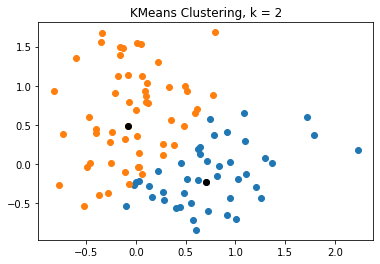

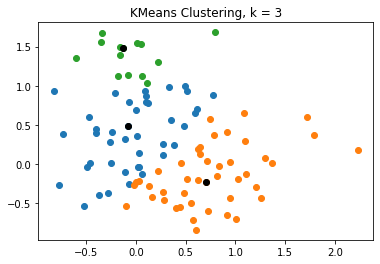

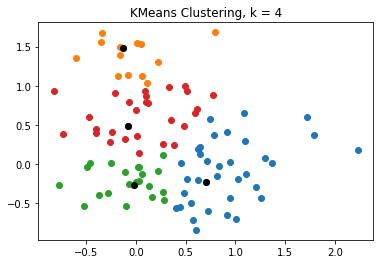

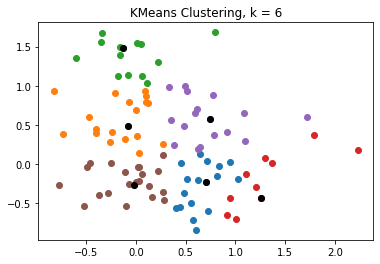

In [ ]:
sig = 0.15
N = 100
k = [2, 3, 4, 6]

# generate data
xKMeans, ykMeans = genData(N, [1, 0], [0, 1], [0, 0], sig)

for i in range(len(k)):
  centroids, labels = kMeans(k[i], xKMeans, 50)
  plotDataKMeans(k[i], labels, centroids, sigma=sig)

As it is possible to observe from the above plots, with a variation of 0.15, the data is better represented with less clusters (labels). Good representations can be found with k=3 or k=4.

### Question 4
- Generate the data set with $\sigma^2 \in \{0.10, 0.25, 0.50\}$.
- For each $\sigma^2$, group the data set into three clusters $(k=3)$ using the $k$-Means algorithm with respect to the Euclidean distance.
- Visualize all data with the centroids that generated the input data, i.e. $\{(-1, 0), (1, 0), (0, 1)\}$ for each $\sigma^2$. Comment.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


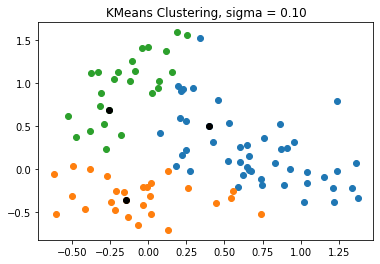

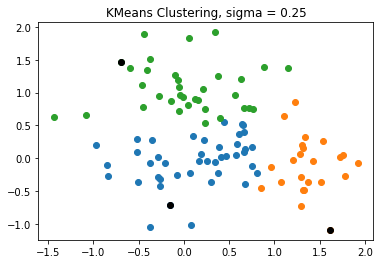

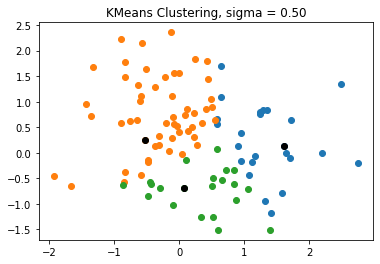

In [ ]:
sig_list = [0.10, 0.25, 0.50]
k = 3
N = 100

for i in range(len(sig_list)):
  xKMeans, ykMeans = genData(N, [1, 0], [0, 1], [0, 0], sig_list[i])
  centroids, labels = kMeans(k, xKMeans, 50)
  plotDataKMeans(k, labels, centroids, sigma=sig_list[i], plotD='sigPlot')

The obtained result is consisting. As the variance increases, the distance of all the points generated from *genData()* function are increased. This way, the classification with only 3 clusters can become more challenging. 

# Part 2: Real data

## $k$-NN regression : Szefed-weather data-set
In this part we will apply the k-NN algorithm for prediction.

Let’s use the Szeged-weather data set that can be downloaded in <code>https://www.kaggle.com/budincsevity/szeged-weather/data</code>.

We want to predict the apparent temperature given humidity and temperature. Apparent temperature is a notion of temperature that reflects human perception.

**Short description:** The Szeged-weather data set set is a daily/hourly summary for Szeged, Hungary area, between $2006$ and $2016$, in terms of temperature, humidity, apparent temperature, pressure, wind speed, among other measurements.

**Data Preparation:** For simplicity we will consider only three attributes: apparent temperature, humidity, and temperature, and only the first $2000 $ samples of the data set. We will use K-Fold Cross Validation with $5$ folds.

### Question 5:
Visualize all data set in terms of temperature (x-axis), humidity (y-axis), and apparent temperature (color). You should obtain a figure similar to Figure 5a.

<img src="https://i.ibb.co/zrksRTq/Screenshot-2022-10-23-164818.png" alt="Screenshot-2022-10-23-164818" border="0">

*Figure 5: Visualization of three attributes of the Szeged-weather data set: (a) shows all data set and (b) shows only the first 2000 samples of the data set.*

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
import seaborn as sns

# get file from google drive
gdd.download_file_from_google_drive(file_id='1aLCw9yw5kv7tlOLnLKFxrtFY9m86JIoH',
                                    dest_path='./weatherHistory/archive.zip',
                                    unzip=True)

weatherH = pd.read_csv('weatherHistory/weatherHistory.csv')

# process data
weatherH = weatherH[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']] # all data
weatherP = weatherH[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity']]
weatherP.drop(weatherP.tail(weatherP.shape[0]-2000).index, inplace = True)  # crop last rows

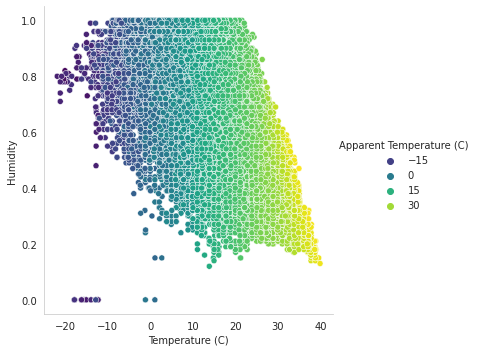

In [ ]:
# plot all the data
sns.set_style('whitegrid', {'axes.grid' : False})
sns.relplot(
    data=weatherH, 
    x='Temperature (C)', 
    y='Humidity', 
    hue='Apparent Temperature (C)',
    palette=sns.color_palette("viridis", as_cmap=True))
plt.show()

### Question 6:
- Consider the first $2000$ samples of the data set, and plot them. You should get Figure 5b.
- The prediction, given by the $k$-NN algorithm, is computed by taking into account the average of the values of $k$ nearest neighbors. Predict the apparent temperature given humidity and temperature using the $k$-NN algorithm with respect to the Euclidean distance for $k = 1$.
- Compute the mean squared error of the test data set.

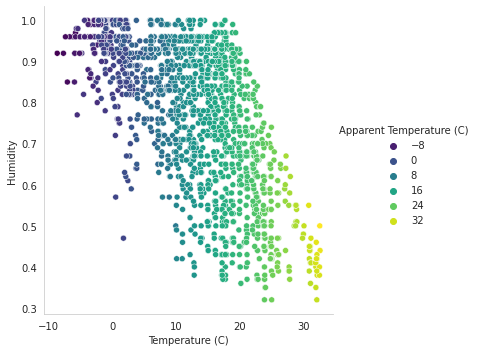

In [ ]:
# plot 2000 samples
sns.set_style('whitegrid', {'axes.grid' : False})
sns.relplot(
    data=weatherP, 
    x='Temperature (C)', 
    y='Humidity', 
    hue='Apparent Temperature (C)',
    palette=sns.color_palette("viridis", as_cmap=True))
plt.show()

In [ ]:
k = 1

# divide x (temp and humidity) and y (app. temp.)
weatherA = np.array(weatherP) 
x = np.array([weatherA[:, 0], weatherA[:, 1]]).T
y = np.array([weatherA[:, 2]]).T

# get the train and test samples (80% training)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)

# train and get the mean square error
yPred = knnClassifier(k, xTrain.T, yTrain, xTest.T)
mse = met.mean_squared_error(yTest, yPred)
print('MSE:%1.3f' %mse)

MSE:1.396


It is possible to say that the prediction is good. The Mean Square Error is not so distant from MSE equals to zero.

### Question 7:
- Perform K-Fold Cross Validation with $5$ Folds with different numbers of neighbors $k \in \{1, 3, 5, 7, 10, 15\}$, and showcase the best model.
- Plot the mean squared error of the test data set *versus* the parameter $k$, use error bars to represent the standard deviation of the error for each model. Comment.

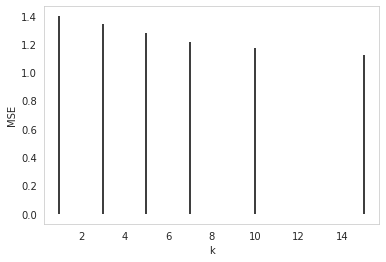

In [ ]:
k_list = [1, 3, 5, 7, 10, 15]
N_folds = 5
N_k = len(k_list)

# using previous test and train arrays
mse = np.zeros([N_k, N_folds])
for i in range(N_k):
  for j in range(N_folds):
    mse[i, j] = met.mean_squared_error(yTest, knnClassifier(k_list[i], xTrain.T, yTrain, xTest.T))

# plotting MSE x k
plt.vlines(k_list, np.zeros(len(mse)), np.mean(mse, axis=1))
plt.xlabel("k")
plt.ylabel("MSE")
plt.show()

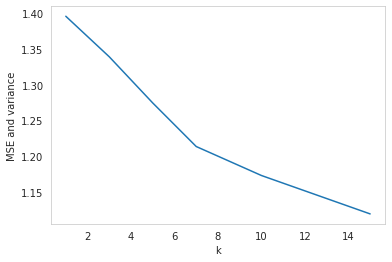

In [ ]:
plt.errorbar(k_list, np.mean(mse, axis=1), yerr = np.std(mse, axis=1))
plt.xlabel("k")
plt.ylabel("MSE and variance")
plt.show()

Considering the given data, Weather History, the predictions are better as the number of k is increases. 

# Some References:

https://www.youtube.com/watch?v=09mb78oiPkA : $k$-NN

https://www.youtube.com/watch?v=hDmNF9JG3lo : $k$-Means

https://www.youtube.com/watch?v=uoTBdCODGvk : Model Selection and Cross Validation

https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/ : Numpy Broadcasting and Vectorization

# Other References used to resolve the questions:

[Create a K-Means Clustering Algorithm](https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670)